### Finding the best K using K-means and IOU method.

## Organisation of JSON File
keys :
   1. info - Genric Infoormation on the file like year, version, url, description
   2. images - this contains information of images
        * id - unique value
        * width - width of the image
        * height - height of the image
        * file_name - name of the file
        * license   - licence if any
        * date_captured - date when captured
   3.   annotation - information about annotation that is done manually in vgg annotator
        * id  - unique value
        * image_id - which is the id of images. By this we can join images and annottaion fields
        * segmentation- Co-Ordinates of the bbox. For rectangle there will be 8 coordinates(4 x,y groups) - top-left,top-right, bottom-left, bottom-right.
        * area- area of bounding box
        * bbox - 4 points. top-left x point,top-left y point, width of bbox, height of bbox 
        * iscrowd - NA
        * id - ID for each bounding box.
        * image_id - Image ID 
        * category_id - NA 
   4.   licence
   5.  Categories - This will have the information of the field we annotated.like class, type -- whatever fields we chose


In [25]:
%rm -rf TSAI-EVA5/

In [26]:
!git clone https://github.com/Anjan-AI/TSAI-EVA5.git
!ls
!pwd

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (496/496), done.
remote: Compressing objects: 100% (422/422), done.
remote: Total 1103 (delta 158), reused 388 (delta 63), pack-reused 607
Receiving objects: 100% (1103/1103), 65.87 MiB | 32.72 MiB/s, done.
Resolving deltas: 100% (413/413), done.
sample_data  TSAI-EVA5
/content


In [27]:
import sys
sys.path.append('/content/TSAI-EVA5/Session 12 - Object Localization YOLO ( Part 1)/')

In [28]:
import json 
import pandas as pd

path = '/content/TSAI-EVA5/Session 12 - Object Localization YOLO ( Part 1)/Image_Data/Images/ImagesSet3_coco.json' # path of the json file  
# Opening JSON file 
f = open(path) 
  
# returns JSON object as  

data = json.load(f) 
 

print(data.keys())
print('\n\n')
images = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())
 
# Closing file 
f.close()
images.tail()

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])





,id,width,height,file_name,license,date_captured
33,34,2560,1920,34.jpg,0,
34,35,335,150,35.jpg,0,
35,36,1300,957,36.jpg,0,
36,37,862,575,37.jpg,0,
37,38,6000,3069,38.jpg,0,


## display the data frames

In [29]:
annotations.tail()
#print(annotations.shape[0])

,segmentation,area,bbox,iscrowd,id,image_id,category_id
242,"[[2650, 800, 2783, 800, 2783, 938, 2650, 938]]",18354,"[2650, 800, 133, 138]",0,243,38,None
243,"[[5475, 583, 5560, 583, 5560, 721, 5475, 721]]",11730,"[5475, 583, 85, 138]",0,244,38,None
244,"[[4966, 620, 5072, 620, 5072, 715, 4966, 715]]",10070,"[4966, 620, 106, 95]",0,245,38,None
245,"[[5687, 567, 5777, 567, 5777, 662, 5687, 662]]",8550,"[5687, 567, 90, 95]",0,246,38,None
246,"[[4049, 625, 4113, 625, 4113, 726, 4049, 726]]",6464,"[4049, 625, 64, 101]",0,247,38,None


## Preprocessing the data , remove unwanted cols 

In [30]:
bbwidth = []
bbheight = []
bbx = []
bby = []
bbox = list(annotations['bbox'])
for i in bbox:
    #print(i)
    bbx.append(i[0])
    bby.append(i[1])
    bbwidth.append(i[2])
    bbheight.append(i[3])
annotations['bbx'] = bbx
annotations['bby'] = bby
annotations['bbwidth'] = bbwidth
annotations['bbheight'] = bbheight
annotations = annotations.rename(columns={"id": "bbox_no"}) #changing the ID so that this kyworrd can be used for assignign the image ID
annotations = annotations.rename(columns={"image_id": "id"}) # changed Image_ID to ID as its the nmae used in Image dataframe and  will be used for merging. 
annotations = annotations.drop(["bbox","bbx","bby","bbox_no","category_id","segmentation","area","iscrowd"],axis =1)
annotations.tail()

,id,bbwidth,bbheight
242,38,133,138
243,38,85,138
244,38,106,95
245,38,90,95
246,38,64,101


In [31]:
images = images.drop(["license","date_captured"],axis = 1)
images.tail()


,id,width,height,file_name
33,34,2560,1920,34.jpg
34,35,335,150,35.jpg
35,36,1300,957,36.jpg
36,37,862,575,37.jpg
37,38,6000,3069,38.jpg


### merging both the data frames.

In [32]:
list(images.columns)

['id', 'width', 'height', 'file_name']

In [33]:
list(annotations.columns)

['id', 'bbwidth', 'bbheight']

In [34]:

finalfile = pd.merge(images, annotations,on='id')

finalfile.tail()

,id,width,height,file_name,bbwidth,bbheight
242,38,6000,3069,38.jpg,133,138
243,38,6000,3069,38.jpg,85,138
244,38,6000,3069,38.jpg,106,95
245,38,6000,3069,38.jpg,90,95
246,38,6000,3069,38.jpg,64,101


## Normalize the Bounding Box values

In [35]:
finalfile['bbwidth'] = finalfile['bbwidth'].div(finalfile['width'])
finalfile['bbheight'] = finalfile['bbheight'].div(finalfile['height'])
finalfile['height'] = finalfile['height'].div(finalfile['height'])
finalfile['width'] = finalfile['width'].div(finalfile['width'])

finalfile.tail()

,id,width,height,file_name,bbwidth,bbheight
242,38,1.0,1.0,38.jpg,0.022167,0.044966
243,38,1.0,1.0,38.jpg,0.014167,0.044966
244,38,1.0,1.0,38.jpg,0.017667,0.030955
245,38,1.0,1.0,38.jpg,0.015000,0.030955
246,38,1.0,1.0,38.jpg,0.010667,0.032910


In [36]:
table_for_kmeans = finalfile.drop(["width","height","file_name","id"],axis = 1)
table_for_kmeans.head()

,bbwidth,bbheight
0,0.116406,0.134031
1,0.079687,0.093194
2,0.083594,0.106806
3,0.100781,0.107853
4,0.078125,0.159162


In [37]:
table_for_kmeans.tail()

,bbwidth,bbheight
242,0.022167,0.044966
243,0.014167,0.044966
244,0.017667,0.030955
245,0.015000,0.030955
246,0.010667,0.032910


## Plotting the Nomralized values 

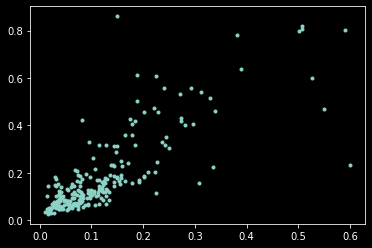

In [38]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.plot(table_for_kmeans['bbwidth'],table_for_kmeans['bbheight'],'.')

### Apply Elbow method to find out K

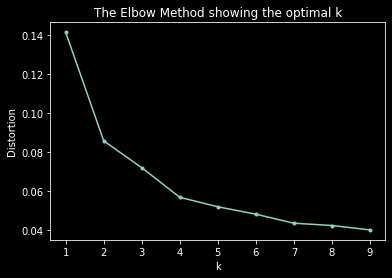

In [39]:

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt



# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(table_for_kmeans)
    kmeanModel.fit(table_for_kmeans)
    distortions.append(sum(np.min(cdist(table_for_kmeans, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) /table_for_kmeans.shape[0])

# Plot the elbow
plt.style.use("dark_background")
plt.plot(K, distortions, '.-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Iou Method to find out K
###IOU(Intersection over union) = intersected area of bbox and anchor box/ Union area of bbox and anchor box

###bw = bounding box width, bh - bounding box height, aw - anchor box width, ah - anchor box height

###IOU = min(bw,aw) min(bh, ah)/bwbh + awah - min(bw,aw) min(bh, ah)

###mean IOU = sum(IOU)/len(IOU)


In [40]:
height = list(table_for_kmeans['bbheight'])
width = list(table_for_kmeans['bbwidth'])
ks = range(1,10)
meaniou = []
for k in ks:
    cl = KMeans(n_clusters=k)
    cl.fit(table_for_kmeans)
    cx = []
    cy = []
    mapcx  = {}
    mapcy = {}
    iou = []
    for i in range(len(width)):
        
        l = cl.labels_[i]
        cx.append(cl.cluster_centers_[l][0])
        cy.append(cl.cluster_centers_[l][1])
        iou.append(min(width[i] ,cx[i])* min(height[i] , cy[i])/(height[i]*width[i]+ cx[i]*cy[i]- min(width[i] , cx[i])* min(height[i] ,cy[i])))
    meaniou.append(sum(iou)/len(width))

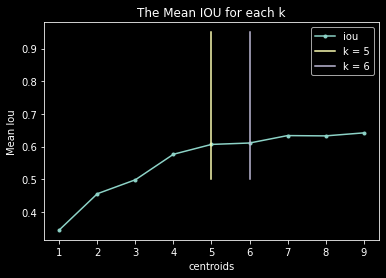

In [41]:
plt.style.use("dark_background")
plt.plot(range(1,10),meaniou,'.-',label = "iou")
plt.plot([5,5],[0.5,0.95],label = "k = 5")
plt.plot([6,6],[0.5,0.95],label = "k = 6")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.title('The Mean IOU for each k')
plt.legend()
plt.show()

In [42]:
meaniou[3],meaniou[4],meaniou[5],meaniou[6]

(0.5762601029789375,
 0.6064154858702097,
 0.6107116739254048,
 0.6334513613015339)

K =6 from elbow method and K =5 from the IOU method.

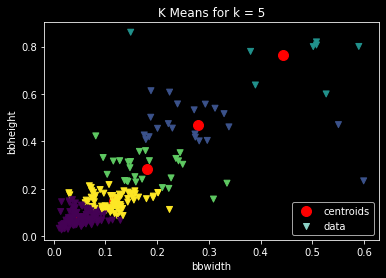

In [43]:
import numpy as np
array_points = np.array(table_for_kmeans)
cl3 = KMeans(5)
cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_kmeans['bbwidth']), list(table_for_kmeans['bbheight']), marker="v",c=list(cl3.labels_.astype(float)), label = "data")
plt.legend()
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 5')
plt.legend()
plt.show()

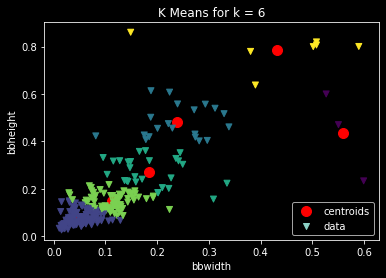

In [44]:
import numpy as np
array_points = np.array(table_for_kmeans)
cl3 = KMeans(6)
cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_kmeans['bbwidth']), list(table_for_kmeans['bbheight']), marker="v",c=list(cl3.labels_.astype(float)), label = "data")
plt.legend()
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 6')
plt.legend()
plt.show()

### by looking at the plot K=6 and K =5 looks almost same, so k=5 would be a good no.